# Modelling of Bot Accounts on Twitter Dataset

In [76]:
# load dependencies
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [77]:
# initialise google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
# load data from gdrive
nodes = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/final_cleaned_crypto_bernardamus_network_nodes (1).csv')
edges = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/final_cleaned_crypto_bernardamus_network_edges (1).csv')

In [79]:
nodes.head()

,Unnamed: 0,Screen Name,Id,Age in Years,# of Followers,# of Followings,Follower/Following Ratio,URL,Verified,Number of Tweets,# of liked Tweets,# of lists,Botometer,Bot: 3.5 Threshold,Bot: 4.0 Threshold
0,0,drumkitt87,14254757,13,321,649,0.49,0,0,3009,28401,6,0.7,0,0
1,1,cryptomichnl,146008010,11,181300,536,338.25,1,0,57312,43979,2367,0.9,0,0
2,2,fatihsk87,2665227374,7,73248,409,179.09,0,0,11859,7887,1882,0.3,0,0
3,3,sp889900,1065823520314140000,3,129,444,0.29,0,0,474,1438,0,1.6,0,0
4,4,rewardiqa,1200106100491720000,2,79551,90,883.90,1,0,45,98,14,1.6,0,0


In [80]:
edges.head()

,Unnamed: 0,Source,Target,hashtag
0,0,drumkitt87,cryptomichnl,ethereum
1,1,drumkitt87,fatihsk87,ethereum
2,2,cryptomichnl,fatihsk87,ethereum
3,3,sp889900,rewardiqa,binance
4,4,sp889900,rewardiqa,rew


# Unsupervised Modelling Exploration

In [81]:
# clean up data for unsupervised modelling
nodes = nodes.drop(['Unnamed: 0', 'Id'], axis=1)
nodes.head()

,Screen Name,Age in Years,# of Followers,# of Followings,Follower/Following Ratio,URL,Verified,Number of Tweets,# of liked Tweets,# of lists,Botometer,Bot: 3.5 Threshold,Bot: 4.0 Threshold
0,drumkitt87,13,321,649,0.49,0,0,3009,28401,6,0.7,0,0
1,cryptomichnl,11,181300,536,338.25,1,0,57312,43979,2367,0.9,0,0
2,fatihsk87,7,73248,409,179.09,0,0,11859,7887,1882,0.3,0,0
3,sp889900,3,129,444,0.29,0,0,474,1438,0,1.6,0,0
4,rewardiqa,2,79551,90,883.90,1,0,45,98,14,1.6,0,0


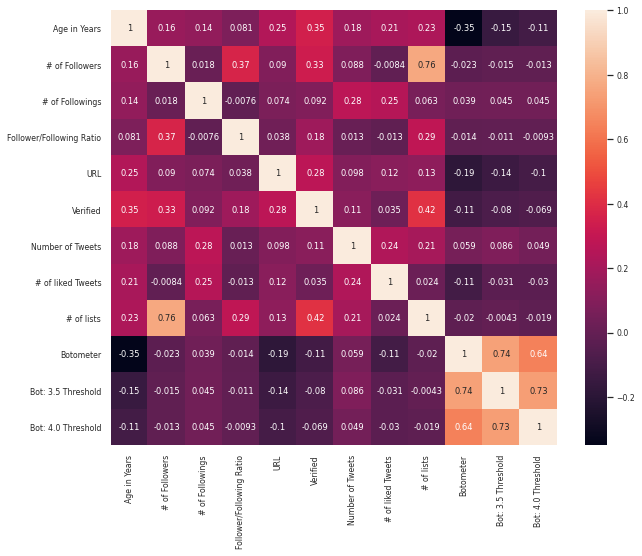

In [82]:
# correlation matrix
corrMatrix = nodes.corr()
sns.set(font_scale=0.7, rc={'figure.figsize':(10,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

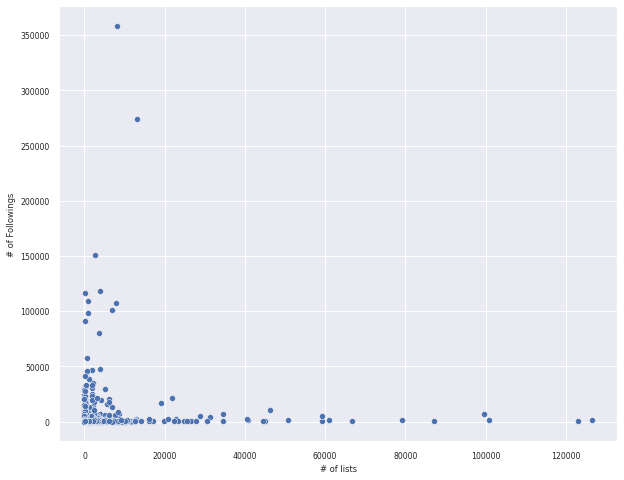

In [83]:
# visualise lists to followings
sns.scatterplot(x=nodes['# of lists'], y=nodes['# of Followings'])
plt.show()

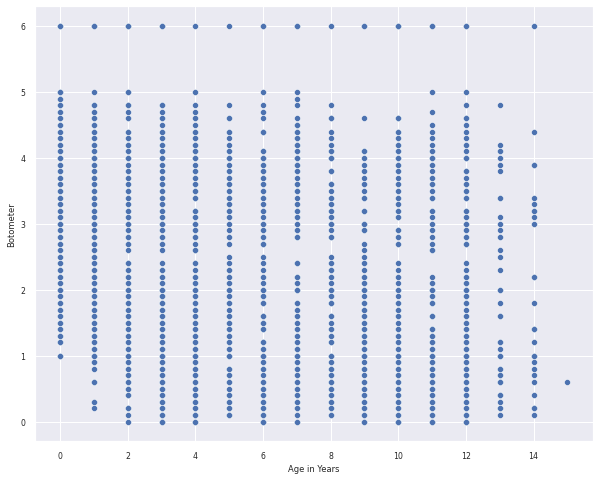

In [84]:
# visualise age to botometer score
sns.scatterplot(x=nodes['Age in Years'], y=nodes['Botometer'])
plt.show()

# Unsupervised Modelling

Unsupervised modelling attempts, may generate interesting insights

In [85]:
# cleaning data for unsupervised models
unsup_nodes = nodes.copy()
unsup_nodes = unsup_nodes.drop(['Screen Name', 'Botometer', 'Bot: 3.5 Threshold', 'Bot: 4.0 Threshold'], axis=1)
unsup_nodes.head()

,Age in Years,# of Followers,# of Followings,Follower/Following Ratio,URL,Verified,Number of Tweets,# of liked Tweets,# of lists
0,13,321,649,0.49,0,0,3009,28401,6
1,11,181300,536,338.25,1,0,57312,43979,2367
2,7,73248,409,179.09,0,0,11859,7887,1882
3,3,129,444,0.29,0,0,474,1438,0
4,2,79551,90,883.90,1,0,45,98,14


In [86]:
# view count of bot samples in original data with botometer
bot_3_5 = sum(nodes['Bot: 3.5 Threshold'])
bot_4 = sum(nodes['Bot: 4.0 Threshold'])
print('Bot 3.5 Count: ', bot_3_5)
print('Bot 4.0 Count: ', bot_4)

Bot 3.5 Count:  1156
Bot 4.0 Count:  696


## KMeans Clustering

In [133]:
# unsupervised models
# k means clustering, sklearn default parameters

kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(unsup_nodes)
unique, counts = np.unique(kmeans, return_counts=True)
dict(zip(unique, counts))

{0: 4913, 1: 11}

Length of predictions:  4924
Length of Botometer labels:  4924



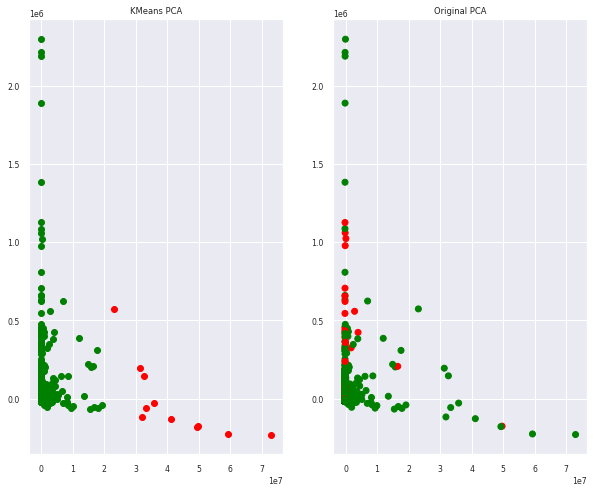

In [134]:
# pca transform data
pca = PCA(2)
pca_df = pca.fit_transform(unsup_nodes)
label = KMeans(n_clusters=2, random_state=0).fit_predict(pca_df)
# filter rows
filtered_label0 = pca_df[label == 0]
filtered_label1 = pca_df[label == 1]
# check length of prediction
print('Length of predictions: ', len(label))
print('Length of Botometer labels: ', len(nodes['Bot: 4.0 Threshold']))
print()
# graph kmeans
plt.subplot(1, 2, 1)
plt.title('KMeans PCA')
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'green')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red')

# view botometer version
# colour labels by botometer threshold
filtered_label0 = pca_df[label == 0]
colours = []
for idx, each in enumerate(pca_df):
  if nodes['Bot: 4.0 Threshold'][idx] == 0:
    colours.append('green')
  else:
    colours.append('red')
# graph original
plt.subplot(1, 2, 2)
plt.title('Original PCA')
plt.scatter(pca_df[:,0], pca_df[:,1], color = colours)
plt.show()

In [135]:
# function to evaluate performance of unsupervised learning
# evaluate accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def unsup_eval(y_true, y_pred):
  print('Accuracy: ', accuracy_score(y_true, y_pred))
  print('F1 score: ', f1_score(y_true, y_pred))
  print()
  print('Classification Report')
  print(classification_report(y_true, y_pred))

In [136]:
# evaluate performance of kmeans
unsup_eval(nodes['Bot: 4.0 Threshold'], kmeans)

Accuracy:  0.8568237205523964
F1 score:  0.002828854314002829

Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      4228
           1       0.09      0.00      0.00       696

    accuracy                           0.86      4924
   macro avg       0.47      0.50      0.46      4924
weighted avg       0.75      0.86      0.79      4924



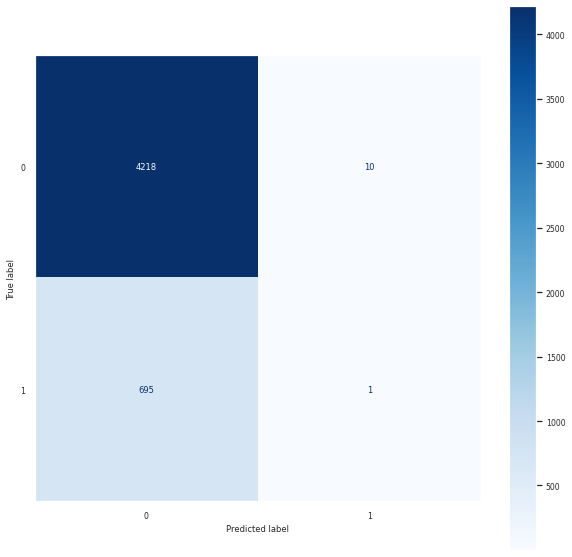

In [137]:
# get confusion matrix of kmeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(nodes['Bot: 4.0 Threshold'], kmeans)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)
plt.grid(None)
plt.show()

## Isolation Forest

In [138]:
# try anomaly detection with outliers
# isolation forest, random selection
# 1 for inliers, -1 for outliers
isoforest = IsolationForest(random_state=0).fit_predict(unsup_nodes)
unique, counts = np.unique(isoforest, return_counts=True)
dict(zip(unique, counts))

{-1: 519, 1: 4405}

Length of predictions:  4924
Length of Botometer labels:  4924



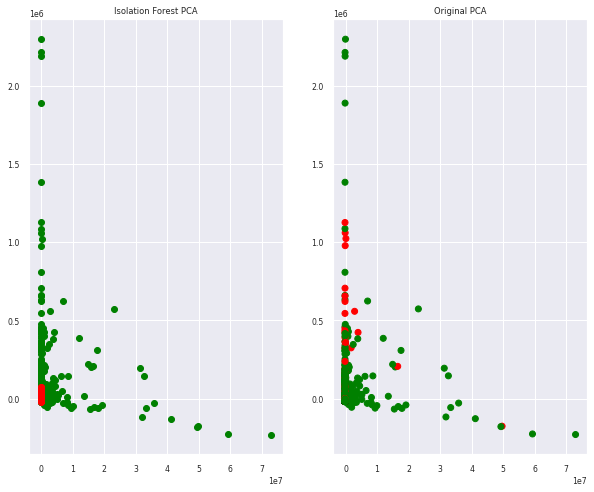

In [139]:
# pca transform data
pca = PCA(2)
pca_df = pca.fit_transform(unsup_nodes)
label = IsolationForest(random_state=0).fit_predict(pca_df)
# filter rows
filtered_label0 = pca_df[label == -1]
filtered_label1 = pca_df[label == 1]
# check length of prediction
print('Length of predictions: ', len(label))
print('Length of Botometer labels: ', len(nodes['Bot: 4.0 Threshold']))
print()
# graph isolation forest
plt.subplot(1, 2, 1)
plt.title('Isolation Forest PCA')
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'green')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red')

# view botometer version
# colour labels by botometer threshold
filtered_label0 = pca_df[label == 0]
colours = []
for idx, each in enumerate(pca_df):
  if nodes['Bot: 4.0 Threshold'][idx] == 0:
    colours.append('green')
  else:
    colours.append('red')
# graph original
plt.subplot(1, 2, 2)
plt.title('Original PCA')
plt.scatter(pca_df[:,0], pca_df[:,1], color = colours)
plt.show()

In [140]:
# evaluate performance of isolation forest
# 1 for inliers (humans), -1 for outliers (bots)
label_isoforest = []
for each in label:
  if each == -1:
    label_isoforest.append(1)
  else:
    label_isoforest.append(0)
unsup_eval(nodes['Bot: 4.0 Threshold'], label_isoforest)

Accuracy:  0.8009748172217709
F1 score:  0.09426987060998152

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4228
           1       0.13      0.07      0.09       696

    accuracy                           0.80      4924
   macro avg       0.49      0.50      0.49      4924
weighted avg       0.76      0.80      0.78      4924



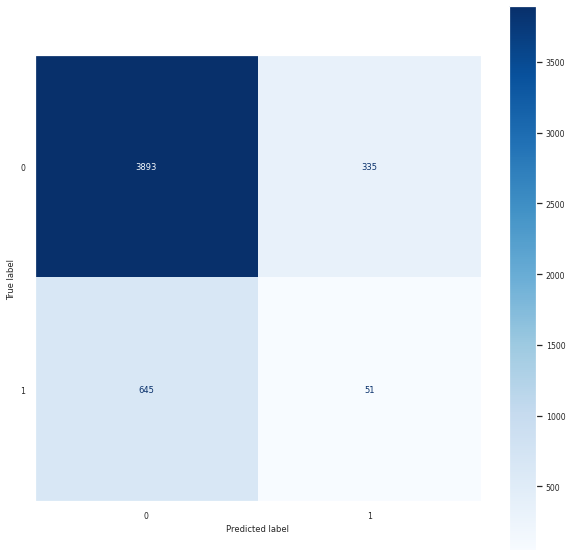

In [141]:
# get confusion matrix of isolation forest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(nodes['Bot: 4.0 Threshold'], label_isoforest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)
plt.grid(None)
plt.show()

## Local Outlier Factor

In [146]:
# local outlier factor
# finding anomalous data points by measuring the local
# deviation of a given data point with respect to its neighbours
lof = LocalOutlierFactor().fit_predict(unsup_nodes)
unique, counts = np.unique(lof, return_counts=True)
dict(zip(unique, counts))

{-1: 267, 1: 4657}

Length of predictions:  4924
Length of Botometer labels:  4924



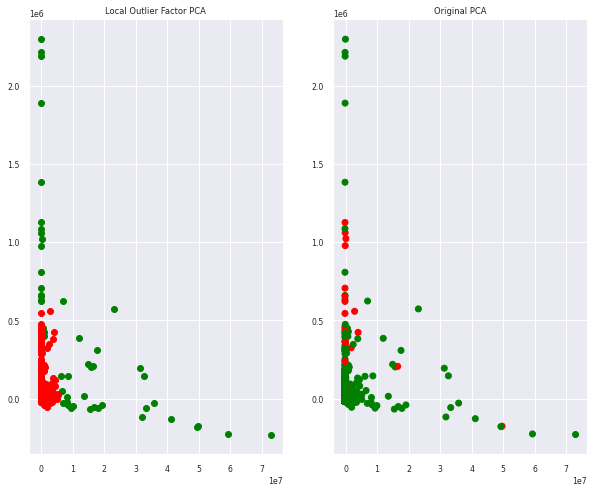

In [147]:
# lof transform data
pca = PCA(2)
pca_df = pca.fit_transform(unsup_nodes)
label = LocalOutlierFactor().fit_predict(pca_df)
# filter rows
filtered_label0 = pca_df[label == -1]
filtered_label1 = pca_df[label == 1]
# check length of prediction
print('Length of predictions: ', len(label))
print('Length of Botometer labels: ', len(nodes['Bot: 4.0 Threshold']))
print()
# graph lof
plt.subplot(1, 2, 1)
plt.title('Local Outlier Factor PCA')
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'green')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red')
 
# view botometer version
# colour labels by botometer threshold
filtered_label0 = pca_df[label == 0]
colours = []
for idx, each in enumerate(pca_df):
  if nodes['Bot: 4.0 Threshold'][idx] == 0:
    colours.append('green')
  else:
    colours.append('red')
# graph original
plt.subplot(1, 2, 2)
plt.title('Original PCA')
plt.scatter(pca_df[:,0], pca_df[:,1], color = colours)
plt.show()

In [148]:
# evaluate performance of local outlier factor
# 1 for inliers (humans), -1 for outliers (bots)
label_lof = []
for each in label:
  if each == -1:
    label_lof.append(1)
  else:
    label_lof.append(0)
unsup_eval(nodes['Bot: 4.0 Threshold'], label_lof)

Accuracy:  0.8436230706742486
F1 score:  0.08333333333333333

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4228
           1       0.24      0.05      0.08       696

    accuracy                           0.84      4924
   macro avg       0.55      0.51      0.50      4924
weighted avg       0.77      0.84      0.80      4924



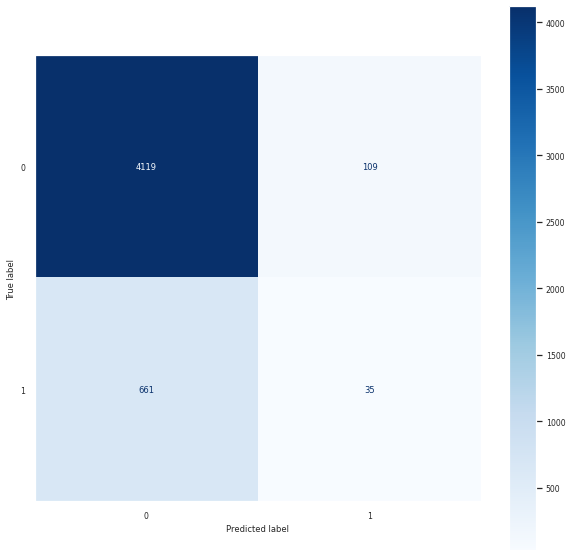

In [149]:
# get confusion matrix of local outlier factor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(nodes['Bot: 4.0 Threshold'], label_lof)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)
plt.grid(None)
plt.show()

# Supervised Modelling
Experiments with supervised modelling, with a focus on Random Forest

In [ ]:
# supervised model splitting
# split out botometer label and remove unnecessary botometer scores
 
labels1 = nodes['Bot: 3.5 Threshold']
labels2 = nodes['Bot: 4.0 Threshold']
sup_nodes = nodes.copy()
sup_nodes = sup_nodes.drop(['Screen Name', 'Botometer', 'Bot: 3.5 Threshold', 'Bot: 4.0 Threshold'], axis=1)
 
X_train, X_test, y_train, y_test = train_test_split(sup_nodes, labels1, test_size=0.3, random_state=0)

In [ ]:
# code from: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# random forest model on 3.5 threshold
# uses randomsearch to optimize hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# parameters of best model
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 400}

In [ ]:
# evaluate results
def evaluate(model, X_test, y_test):
    score = model.score(X_test, y_test)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(score*100))
    print()
    return score
base_model = RandomForestClassifier(random_state = 0)
base_model.fit(X_train, y_train)
print('Base Model')
base_accuracy = evaluate(base_model, X_test, y_test)
pred = base_model.predict(X_test)

best_random = rf_random.best_estimator_
print('Random Model')
bpred = best_random.predict(X_test)
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 83.36%.

Random Model
Model Performance
Accuracy = 84.10%.

Improvement of 0.89%.


In [ ]:
# get a classification report
print('3.5 Threshold')
print('Base Model')
print(classification_report(y_test, pred))
print()
print('Tuned Model')
print(classification_report(y_test, bpred))

3.5 Threshold
Base Model
              precision    recall  f1-score   support

           0       0.86      0.94      0.89      1112
           1       0.73      0.52      0.61       366

    accuracy                           0.83      1478
   macro avg       0.79      0.73      0.75      1478
weighted avg       0.82      0.83      0.82      1478


Tuned Model
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1112
           1       0.76      0.53      0.62       366

    accuracy                           0.84      1478
   macro avg       0.81      0.74      0.76      1478
weighted avg       0.83      0.84      0.83      1478



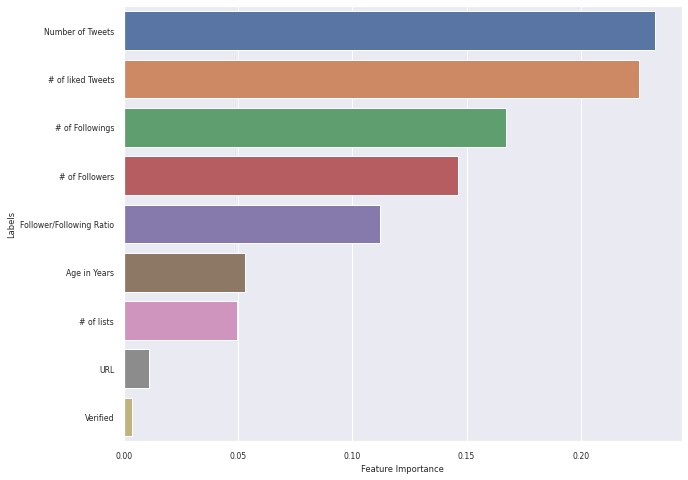

In [ ]:
# plot feature importance, base model
df = pd.DataFrame({'Feature Importance':base_model.feature_importances_,
                   'Labels':sup_nodes.columns})
sns.barplot(x='Feature Importance', y='Labels', data=df, order=df.sort_values('Feature Importance',ascending = False).Labels)
plt.show()

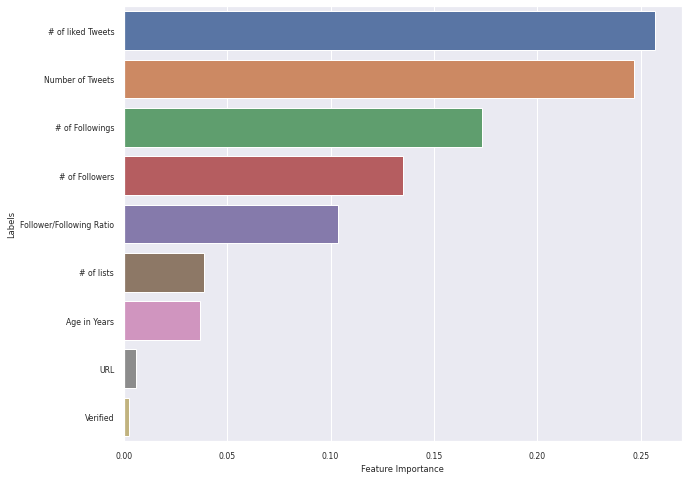

In [ ]:
# plot feature importance, tuned model
df = pd.DataFrame({'Feature Importance':best_random.feature_importances_,
                   'Labels':sup_nodes.columns})
sns.barplot(x='Feature Importance', y='Labels', data=df, order=df.sort_values('Feature Importance',ascending = False).Labels)
plt.show()

In [ ]:
# random forest model, 4.0 threshold
X_train1, X_test1, y_train1, y_test1 = train_test_split(sup_nodes, labels2, test_size=0.3, random_state=0)
rf1 = RandomForestClassifier()
rf_random1 = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random1.fit(X_train1, y_train1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# get parameters of best model
rf_random1.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

In [ ]:
# evaluate results
def evaluate(model, X_test1, y_test1):
    score = model.score(X_test1, y_test1)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(score*100))
    print()
    return score
base_model = RandomForestClassifier(random_state = 0)
base_model.fit(X_train1, y_train1)
print('Base Model')
base_accuracy = evaluate(base_model, X_test1, y_test1)
pred1 = base_model.predict(X_test1)

best_random = rf_random1.best_estimator_
print('Tuned Model')
bpred1 = best_random.predict(X_test1)
random_accuracy = evaluate(best_random, X_test1, y_test1)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 87.42%.

Tuned Model
Model Performance
Accuracy = 88.09%.

Improvement of 0.77%.


In [ ]:
# get classification report
print('4.0 Threshold')
print('Base Model')
print(classification_report(y_test1, pred1))
print()
print('Tuned Model')
print(classification_report(y_test1, bpred1))

4.0 Threshold
Base Model
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1257
           1       0.64      0.37      0.47       221

    accuracy                           0.87      1478
   macro avg       0.77      0.67      0.70      1478
weighted avg       0.86      0.87      0.86      1478


Tuned Model
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1257
           1       0.68      0.39      0.49       221

    accuracy                           0.88      1478
   macro avg       0.79      0.68      0.71      1478
weighted avg       0.87      0.88      0.87      1478



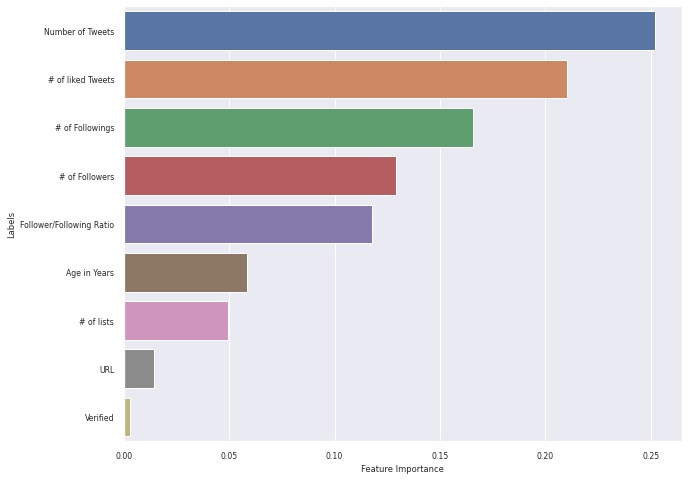

In [ ]:
# plot feature importance, base model
df = pd.DataFrame({'Feature Importance':base_model.feature_importances_,
                   'Labels':sup_nodes.columns})
sns.barplot(x='Feature Importance', y='Labels', data=df, order=df.sort_values('Feature Importance',ascending = False).Labels)
plt.show()

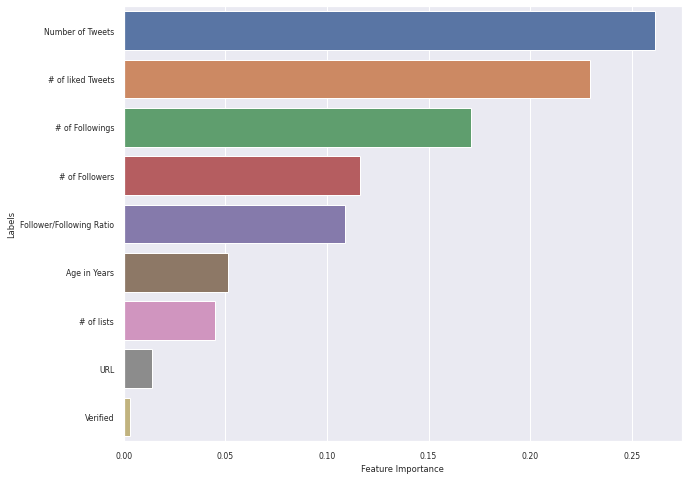

In [ ]:
# plot feature importance, tuned model
df = pd.DataFrame({'Feature Importance':best_random.feature_importances_,
                   'Labels':sup_nodes.columns})
sns.barplot(x='Feature Importance', y='Labels', data=df, order=df.sort_values('Feature Importance',ascending = False).Labels)
plt.show()

# Experiments with XGBoost
Simple out-of-the-box classification

In [ ]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(sup_nodes, labels2, stratify=labels2, test_size=0.3)
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.7994655001231739
Recall = 0.6512531059003623
Accuracy = 0.8849797023004059


In [ ]:
print(classification_report(y_test, best_preds))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1269
           1       0.70      0.33      0.44       209

    accuracy                           0.88      1478
   macro avg       0.80      0.65      0.69      1478
weighted avg       0.87      0.88      0.87      1478



In [ ]:
# view count of human : bots
count1 = nodes['Bot: 3.5 Threshold'].value_counts()
total1 = round(count1[1]/(count1[0]+count1[1])*100, 2)
count2 = nodes['Bot: 4.0 Threshold'].value_counts()
total2 = round(count2[1]/(count2[0]+count2[1])*100, 2)

print('3.5 Bots Percentage: ', total1)
print('4.0 Bots Percentage: ', total2)

3.5 Bots Percentage:  23.48
4.0 Bots Percentage:  14.13


# Experiments with Oversampling

In [ ]:
# code from: https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc#:~:text=SMOTE%20is%20an%20over%2Dsampling,on%20generating%20synthetic%20tabular%20data.&text=That%20is%2C%20for%20each%20one,new%20synthetic%20data%20is%20generated.
 
from imblearn.over_sampling import SMOTE
import math
 
def smote(x, y):
    # Synthetic Minority Over-samping Technique
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
      
    smote = SMOTE(sampling_strategy=1, 
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)
    
    return x, y
 
# SMOTE oversampling implementation
from imblearn.over_sampling import SMOTE
# transform the dataset
X, y = smote(sup_nodes, labels1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# random forest model, 4.0 threshold
rf2 = RandomForestClassifier()
rf_random2 = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random2.fit(X_train2, y_train2)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# evaluate the results
def evaluate(model, X_test2, y_test2):
    score = model.score(X_test2, y_test2)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(score*100))
    print()
    return score
base_model = RandomForestClassifier(random_state = 0)
base_model.fit(X_train2, y_train2)
print('Base Model')
base_accuracy = evaluate(base_model, X_test2, y_test2)
pred2 = base_model.predict(X_test2)

best_random = rf_random2.best_estimator_
print('Tuned Model')
bpred2 = best_random.predict(X_test2)
random_accuracy = evaluate(best_random, X_test2, y_test2)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 87.17%.

Tuned Model
Model Performance
Accuracy = 87.35%.

Improvement of 0.20%.


In [ ]:
# get classification report
print('4.0 Threshold')
print('Base Model')
print(classification_report(y_test2, pred2))
print()
print('Tuned Model')
print(classification_report(y_test2, bpred2))

4.0 Threshold
Base Model
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1104
           1       0.89      0.85      0.87      1157

    accuracy                           0.87      2261
   macro avg       0.87      0.87      0.87      2261
weighted avg       0.87      0.87      0.87      2261


Tuned Model
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1104
           1       0.89      0.86      0.87      1157

    accuracy                           0.87      2261
   macro avg       0.87      0.87      0.87      2261
weighted avg       0.87      0.87      0.87      2261



# Final Unified Pre-processing Random Forest Model
We will make use of a shared pre-processed dataset to better compare the results of different models across the project

In [ ]:
# load new imbalanced dataset
# load from gdrive
nodes_train = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/nodes_train.csv')
nodes_val = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/nodes_validate.csv')
nodes_test = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/nodes_test.csv')

# load new balanced dataset
# data has been undersampled to handle the imbalanced dataset
nodes_train_bal = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/nodes_train_balanced.csv')
nodes_val_bal = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/nodes_validate_balanced.csv')
nodes_test_bal = pd.read_csv('/content/drive/MyDrive/AI Capstone Project/nodes_test_balanced.csv')

In [ ]:
nodes_train.head()

,Screen Name,Age in Years,# of Followers,# of Followings,Follower/Following Ratio,URL,Verified,Number of Tweets,# of liked Tweets,# of lists,Bot: 4.0 Threshold
0,martybent,10,55197,2895,19.07,1,0,46702,110325,1407,0
1,smileym24,0,3,15,0.20,1,0,29,14,0,0
2,cybersecboardrm,7,44664,17526,2.55,1,0,76009,20938,2329,0
3,mickalamasse1,3,1817,2,908.50,1,0,16,19,1,0
4,durerus,8,1079,1071,1.01,0,0,24540,20052,48,0


In [ ]:
# compare number of samples between imbalanced and balanced dataset
print(len(nodes_train))
print(len(nodes_val))
print(len(nodes_test))
print()
print(len(nodes_train_bal))
print(len(nodes_val_bal))
print(len(nodes_test_bal))

2954
985
985

834
279
279


In [ ]:
# separate out prediction labels
lb_nodes_train = nodes_train['Bot: 4.0 Threshold']
lb_nodes_val = nodes_val['Bot: 4.0 Threshold']
lb_nodes_test = nodes_test['Bot: 4.0 Threshold']

lb_nodes_train_bal = nodes_train_bal['Bot: 4.0 Threshold']
lb_nodes_val_bal = nodes_val_bal['Bot: 4.0 Threshold']
lb_nodes_test_bal = nodes_test_bal['Bot: 4.0 Threshold']

In [ ]:
# remove screen name and labels from data, NLP analysis could potentially be employed for screen name
nodes_train = nodes_train.drop(['Screen Name', 'Bot: 4.0 Threshold'], axis=1)
nodes_val = nodes_val.drop(['Screen Name', 'Bot: 4.0 Threshold'], axis=1)
nodes_test = nodes_test.drop(['Screen Name', 'Bot: 4.0 Threshold'], axis=1)

nodes_train_bal = nodes_train_bal.drop(['Screen Name', 'Bot: 4.0 Threshold'], axis=1)
nodes_val_bal = nodes_val_bal.drop(['Screen Name', 'Bot: 4.0 Threshold'], axis=1)
nodes_test_bal = nodes_test_bal.drop(['Screen Name', 'Bot: 4.0 Threshold'], axis=1)

## Imbalanced Dataset

In [ ]:
# random forest model, 4.0 threshold, imbalanced
rf3 = RandomForestClassifier()
rf_random3 = RandomizedSearchCV(estimator = rf3, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random3.fit(nodes_train, lb_nodes_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# evaluate results
def evaluate(model, nodes_test, lb_nodes_test):
    score = model.score(nodes_test, lb_nodes_test)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(score*100))
    print()
    return score
base_model = RandomForestClassifier(random_state = 0)
base_model.fit(nodes_train, lb_nodes_train)
print('Base Model')
base_accuracy = evaluate(base_model, nodes_test, lb_nodes_test)
pred3 = base_model.predict(nodes_test)

best_random = rf_random3.best_estimator_
print('Tuned Model')
bpred3 = best_random.predict(nodes_test)
random_accuracy = evaluate(best_random, nodes_test, lb_nodes_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 89.14%.

Tuned Model
Model Performance
Accuracy = 89.75%.

Improvement of 0.68%.


In [ ]:
# get classification report
print('4.0 Threshold')
print('Base Model')
print(classification_report(lb_nodes_test, pred3))
print()
print('Tuned Model')
print(classification_report(lb_nodes_test, bpred3))

4.0 Threshold
Base Model
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       850
           1       0.69      0.37      0.48       135

    accuracy                           0.89       985
   macro avg       0.80      0.67      0.71       985
weighted avg       0.88      0.89      0.88       985


Tuned Model
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       850
           1       0.77      0.36      0.49       135

    accuracy                           0.90       985
   macro avg       0.84      0.67      0.72       985
weighted avg       0.89      0.90      0.88       985



In [ ]:
# get averaged f1 score
from sklearn.metrics import f1_score
print('4.0 Threshold')
print('Base Model')
print(f1_score(lb_nodes_test, pred3))
print()
print('Tuned Model')
print(f1_score(lb_nodes_test, bpred3))

4.0 Threshold
Base Model
0.4830917874396135

Tuned Model
0.49246231155778897


In [ ]:
# get best parameters of tuned model
rf_random3.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1200}

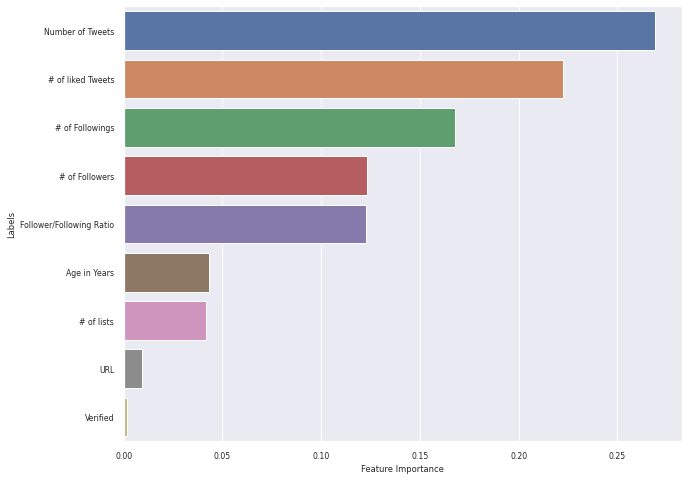

In [ ]:
# plot feature importance, tuned model, imbalanced dataset
df = pd.DataFrame({'Feature Importance':best_random.feature_importances_,
                   'Labels':sup_nodes.columns})
sns.barplot(x='Feature Importance', y='Labels', data=df, order=df.sort_values('Feature Importance',ascending = False).Labels)
plt.show()

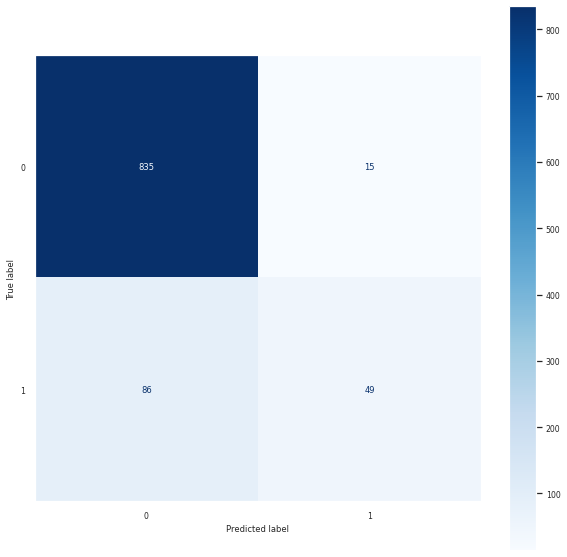

In [ ]:
# get confusion matrix of best performing model, tuned model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(lb_nodes_test, bpred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)
plt.grid(None)
plt.show()

## Undersampled Dataset

In [ ]:
# random forest model, 4.0 threshold, undersampled dataset
rf4 = RandomForestClassifier()
rf_random4 = RandomizedSearchCV(estimator = rf4, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random4.fit(nodes_train_bal, lb_nodes_train_bal)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# evaluate results
def evaluate(model, nodes_test_bal, lb_nodes_test_bal):
    score = model.score(nodes_test_bal, lb_nodes_test_bal)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(score*100))
    print()
    return score
base_model = RandomForestClassifier(random_state = 0)
base_model.fit(nodes_train_bal, lb_nodes_train_bal)
print('Base Model')
base_accuracy = evaluate(base_model, nodes_test_bal, lb_nodes_test_bal)
pred4 = base_model.predict(nodes_test_bal)

best_random = rf_random4.best_estimator_
print('Tuned Model')
bpred4 = best_random.predict(nodes_test_bal)
random_accuracy = evaluate(best_random, nodes_test_bal, lb_nodes_test_bal)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 78.49%.

Tuned Model
Model Performance
Accuracy = 77.78%.

Improvement of -0.91%.


In [ ]:
# get classification report
print('4.0 Threshold')
print('Base Model')
print(classification_report(lb_nodes_test_bal, pred4))
print()
print('Tuned Model')
print(classification_report(lb_nodes_test_bal, bpred4))

4.0 Threshold
Base Model
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       146
           1       0.81      0.72      0.76       133

    accuracy                           0.78       279
   macro avg       0.79      0.78      0.78       279
weighted avg       0.79      0.78      0.78       279


Tuned Model
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       146
           1       0.79      0.72      0.76       133

    accuracy                           0.78       279
   macro avg       0.78      0.78      0.78       279
weighted avg       0.78      0.78      0.78       279



In [ ]:
# get averaged f1 score
print('4.0 Threshold')
print('Base Model')
print(f1_score(lb_nodes_test_bal, pred4))
print()
print('Tuned Model')
print(f1_score(lb_nodes_test_bal, bpred4))

4.0 Threshold
Base Model
0.7619047619047619

Tuned Model
0.7559055118110235


In [ ]:
# get parameters of best performing model between untuned and tuned, in this case, from untuned
base_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

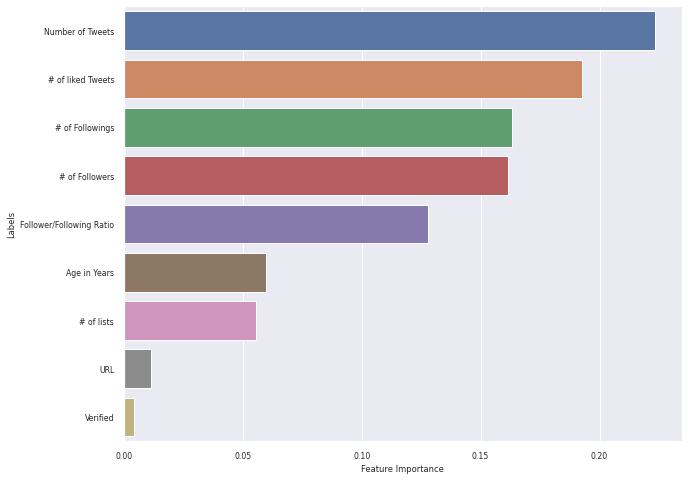

In [ ]:
# plot feature importance, untuned model, balanced dataset
df = pd.DataFrame({'Feature Importance':base_model.feature_importances_,
                   'Labels':sup_nodes.columns})
sns.barplot(x='Feature Importance', y='Labels', data=df, order=df.sort_values('Feature Importance',ascending = False).Labels)
plt.show()

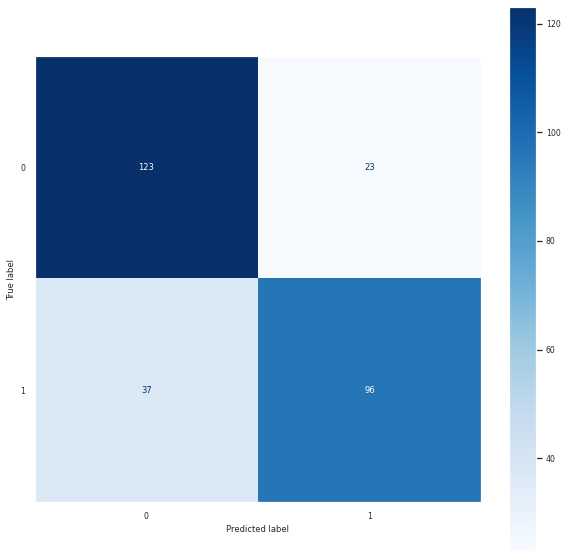

In [ ]:
# get confusion matrix of best performing model, untuned model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(lb_nodes_test_bal, pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)
plt.grid(None)
plt.show()